In [ ]:
# 元ファイルは、kpop_jpop_umap_world.ipynb

In [10]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colorbar as mcolorbar
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import itertools
from itertools import combinations
from collections import Counter
from tqdm import tqdm

import networkx as nx
import igraph as ig
import leidenalg

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

## 読み込みはここから

In [5]:
import pandas as pd

df_user_genre_year = pd.read_pickle("./pickle_data/user_genre_year_20250428.pkl")

In [8]:
clusters = df_user_genre_year["cluster"].tolist()

In [12]:
# --- 2. 全期間のデータを対象に TF-IDF ベクトル化 ---
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_user_genre_year['top_tag'])

/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


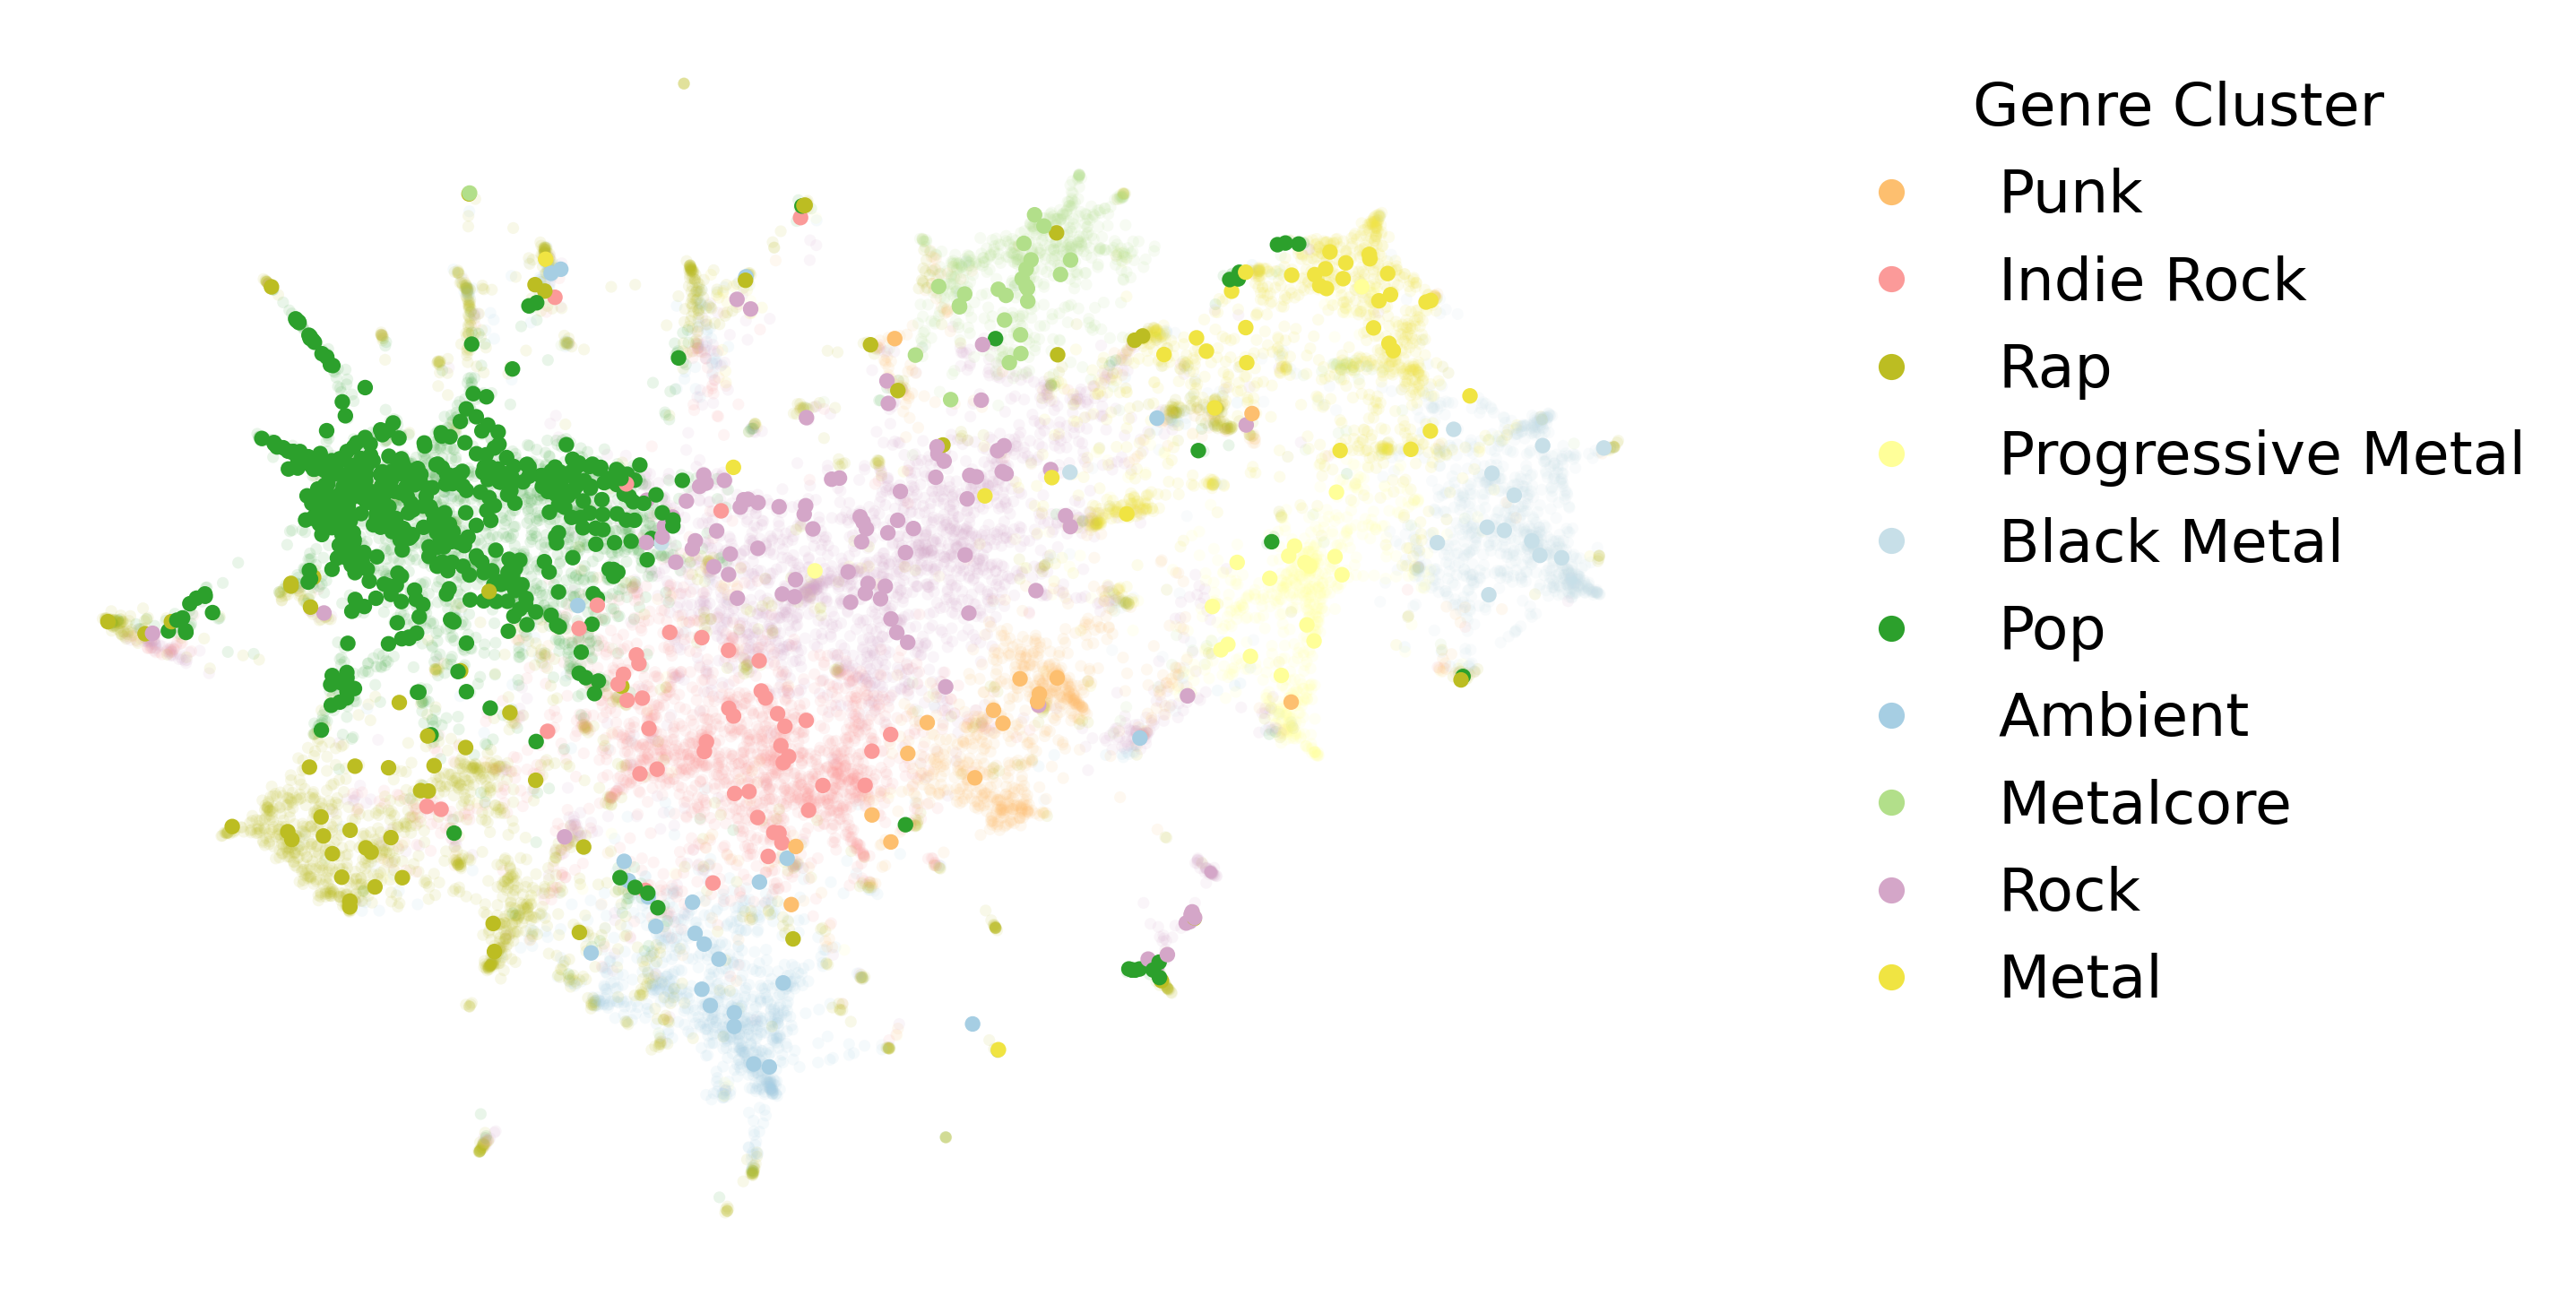

In [13]:
## 再開する場合は、下記のセルから始めないとエラーでます。
# --- 2. 全期間のデータを対象に TF-IDF ベクトル化 ---
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df_user_genre_year['top_tag'])

import umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import scienceplots

# --- スタイル設定 ---
plt.rcParams['figure.dpi'] = 300
plt.style.use(['nature'])
plt.rc('font', size=9)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=1.2)

# --- クラスタラベルとジャンル名マッピング ---
cluster_mapping = {
    0: 'Punk',
    1: 'Indie Rock',
    2: 'Rap',
    3: 'Progressive Metal',
    4: 'Black Metal',
    5: 'Pop',
    6: 'Ambient',
    7: 'Metalcore',
    8: 'Rock',
    9: 'Metal',
}

# --- クラスタごとの色マッピング（薄め + Popは濃い緑）---
cluster_color_map = {
    'Ambient':          '#a6cee3',  # 明るい水色
    'Pop':              '#2ca02c',  # 鮮やか緑（指定通り）
    'Punk':             '#fdbf6f',  # 明るいオレンジ
    'Rock':             '#d4a6c8',  # ラベンダー
    'Progressive Metal':'#ffff99',  # 薄黄色
    'Metalcore':        '#b2df8a',  # 明るい緑
    'Indie Rock':       '#fb9a99',  # ピンクレッド
    'Black Metal':      '#c7dfe8',  # 濃めのブルー（明確に区別）
    'Rap':              '#bcbd22',  # 紫（やや濃いめ、Popと被らない）
    'Metal':            '#f0e442',  # イエローグリーン（目立つ）
}

# --- クラスタ数と特徴量 ---
num_clusters = len(set(clusters))
X_array = X.toarray()

# --- UMAP 次元削減 ---
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_array)

# --- 各クラスタに対応する色を生成 ---
colors = [cluster_color_map.get(cluster_mapping.get(i, ""), "#cccccc") for i in range(num_clusters)]
point_colors = np.array([colors[int(c)] for c in clusters])

# --- フィルタリング（ジャンル出現回数） ---
genre = 'k-pop'
df_user_genre_year['kpop_count'] = df_user_genre_year['top_tag'].str.count(genre)
mask_kpop_10 = df_user_genre_year['kpop_count'] >= 10
mask_non_kpop = ~mask_kpop_10

# --- 描画 ---
fig, ax = plt.subplots(figsize=(8, 6))

# 不透明度で層を分けて描画
ax.scatter(X_umap[mask_non_kpop, 0], X_umap[mask_non_kpop, 1],
           color=point_colors[mask_non_kpop], alpha=0.1,linewidths=0, s=10)
ax.scatter(X_umap[mask_kpop_10, 0], X_umap[mask_kpop_10, 1],
           color=point_colors[mask_kpop_10], alpha=1, s=10)

# 軸・枠なし
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlabel("")
ax.set_ylabel("")

# タイトル
#ax.set_title("K-pop")

# 凡例の生成
labels = [cluster_mapping.get(i, f"Cluster {i}") for i in range(num_clusters)]
cluster_handles = [Line2D([0], [0], marker="o", color="w",
                          markerfacecolor=colors[i], markersize=8)
                   for i in range(num_clusters)]

ax.legend(cluster_handles, labels, title="Genre Cluster", fontsize=16,
          bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False, title_fontsize=16)

plt.show()